### Importing required libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, log_loss, roc_auc_score, roc_curve, auc,accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib


### Loading the data

In [4]:
path_data = 'dataset/n1_n2_n3_cleaned/'

In [5]:
df_anodic_1 = pd.read_csv(f'{path_data}anodic_N1.csv')
df_cathodic_1 = pd.read_csv(f'{path_data}cathodic_N1.csv')
df_corrosion_1 = pd.read_csv(f'{path_data}corrosion_N1.csv')

df_anodic_2 = pd.read_csv(f'{path_data}anodic_N2.csv')
df_cathodic_2 = pd.read_csv(f'{path_data}cathodic_N2.csv')
df_corrosion_2 = pd.read_csv(f'{path_data}corrosion_N2.csv')

df_anodic_3 = pd.read_csv(f'{path_data}anodic_N3.csv')
df_cathodic_3 = pd.read_csv(f'{path_data}cathodic_N3.csv')
df_corrosion_3 = pd.read_csv(f'{path_data}corrosion_N3.csv')

In [6]:
# df_anodic_1, df_cathodic_1, df_corrosion_1,
# df_anodic_2, df_cathodic_2, df_corrosion_2,
# df_anodic_3,df_cathodic_3,df_corrosion_3

### Combining all the data (Anodic, Cathodic, Corrosion)

In [7]:
df_combined = pd.concat([df_anodic_1, df_cathodic_1, df_corrosion_1,df_anodic_2, df_cathodic_2, df_corrosion_2,df_anodic_3,df_cathodic_3,df_corrosion_3], axis=0, ignore_index=True)
df_combined.shape

(1586116, 5)

### Removing the duplicate rows

In [8]:
dup_count = pd.DataFrame(df_combined).duplicated().sum()
print(f"Duplicate rows: {dup_count}")

Duplicate rows: 196660


In [9]:
df_combined = df_combined.drop_duplicates()

In [10]:
dup_count = pd.DataFrame(df_combined).duplicated().sum()
print(f"Duplicate rows: {dup_count}")

Duplicate rows: 0


In [11]:
df_combined.shape

(1389456, 5)

In [12]:
numeric_cols = ['accoustic_emmision_data', 'electrochemical_data',
       'mechanical_data']

In [13]:
df_combined.describe()

,time1,accoustic_emmision_data,electrochemical_data,mechanical_data
count,1.389456e+06,1.389456e+06,1.389456e+06,1.389456e+06
mean,1.378078e+03,2.484085e+07,2.270831e-07,6.424831e-02
std,8.171703e+02,1.188633e+08,6.074906e-06,5.808332e-02
min,1.000000e-02,6.540000e+03,-1.260000e-04,0.000000e+00
25%,6.588075e+02,1.910000e+04,-6.470000e-07,3.056626e-02
50%,1.374600e+03,3.520000e+04,8.515325e-08,4.602410e-02
75%,2.075593e+03,1.140000e+05,4.568435e-07,6.996386e-02
max,2.990930e+03,5.740000e+09,1.190000e-03,2.080964e-01


In [14]:
df_combined.isnull().sum()

time1                      0
accoustic_emmision_data    0
electrochemical_data       0
mechanical_data            0
output                     0
dtype: int64

In [15]:
df = df_combined[df_combined.output.isnull()]

In [16]:
df.head()

,time1,accoustic_emmision_data,electrochemical_data,mechanical_data,output


In [17]:
del df

In [18]:
df_combined.output.value_counts()

output
anodic       581851
cathodic     474941
corrosion    332664
Name: count, dtype: int64

### Creating test data

In [86]:

X_1 = df_combined.drop('output', axis=1)
y_1 = df_combined['output']

X_train, X_test, y_train, y_test= train_test_split(X_1, y_1, test_size=0.2, random_state=10)
test = pd.concat([X_test, y_test], axis=1)
dataset = pd.concat([X_train, y_train], axis=1)

In [80]:
dataset.dtypes

time1                      float64
accoustic_emmision_data    float64
electrochemical_data       float64
mechanical_data            float64
output                      object
dtype: object

In [81]:
dataset.columns

Index(['time1', 'accoustic_emmision_data', 'electrochemical_data',
       'mechanical_data', 'output'],
      dtype='object')

In [82]:
dataset.head()

,time1,accoustic_emmision_data,electrochemical_data,mechanical_data,output
1325977,1438.37,22893.0,-1.470000e-06,0.039229,cathodic
658692,2874.66,18300.0,2.267610e-07,0.036747,anodic
492248,406.32,43100.0,7.090000e-07,0.045145,anodic
1040792,35.18,7200.0,1.360000e-05,0.196096,anodic
141679,2128.28,25800.0,4.663870e-07,0.069892,anodic


In [84]:
dataset['output'] = dataset.output.map({'anodic':0, 'cathodic':1, 'corrosion':2})

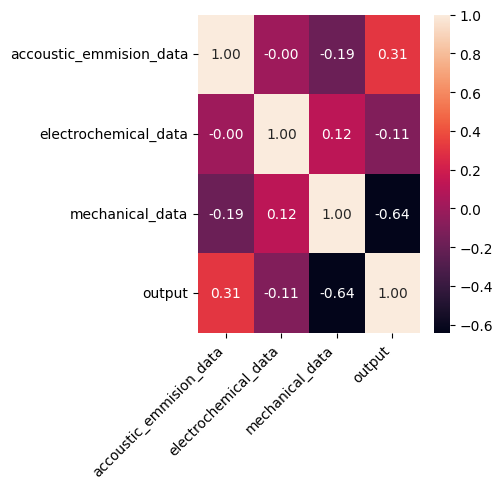

In [85]:
plt.figure(figsize=(5,5))
cm = dataset[['accoustic_emmision_data', 'electrochemical_data', 'mechanical_data','output']].corr()
sns.heatmap(cm, annot=True, fmt='0.2f')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Training the dataset

In [34]:
X = dataset.drop(['output','time1'], axis=1)
y = dataset['output']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [577]:
X.columns

Index(['accoustic_emmision_data', 'electrochemical_data', 'mechanical_data'], dtype='object')

### Model 1 : Lightgbm

In [89]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


model_lgb = LGBMClassifier(
    n_estimators=500,
    max_depth=-1,
    num_leaves=31,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    verbose=50)


model_lgb.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              eval_metric='multi_logloss')


y_pred = model_lgb.predict(X_test)

y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

print(classification_report(y_test_labels, y_pred_labels))

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000015
[LightGBM] [Debug] init for col-wise cost 0.000001 seconds, init for row-wise cost 0.001634 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 889251, number of used features: 3
[LightGBM] [Info] Start training from score -0.870774
[LightGBM] [Info] Start training from score -1.073309
[LightGBM] [Info] Start training from score -1.429214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and dept

### Plotting confusion matrix, classification report

=== CORRECT CLASSIFICATION METRICS ===
Accuracy: 0.999564
Precision: 0.999564
Recall: 0.999564
F1-Score: 0.999564

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93066
           1       1.00      1.00      1.00     76003
           2       1.00      1.00      1.00     53244

    accuracy                           1.00    222313
   macro avg       1.00      1.00      1.00    222313
weighted avg       1.00      1.00      1.00    222313

=== CONFUSION MATRIX ===
[[93063     0     3]
 [    0 75966    37]
 [    3    54 53187]]


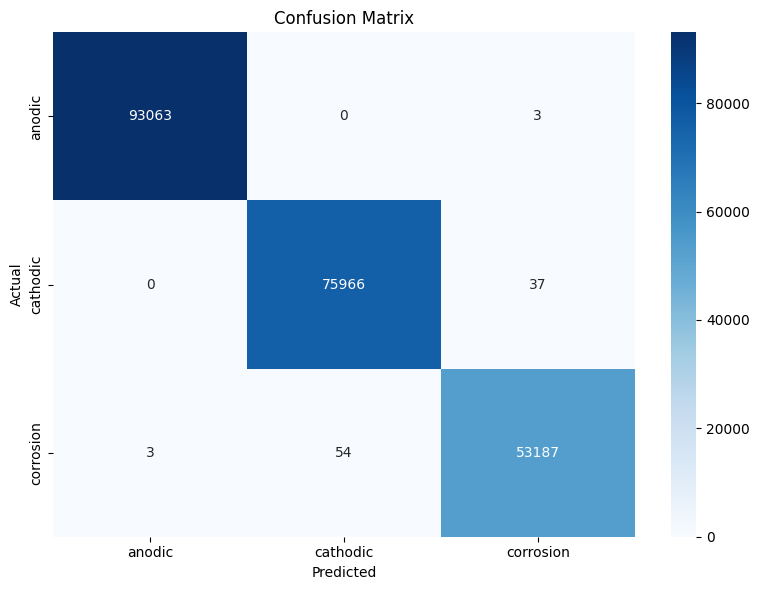

In [90]:
if hasattr(model_lgb, 'classes_'):
    y_test_numeric = np.array([list(model_lgb.classes_).index(label) if label in model_lgb.classes_ else -1
                              for label in y_test])
    y_pred_numeric = np.array([list(model_lgb.classes_).index(label) if label in model_lgb.classes_ else -1
                              for label in y_pred])
else:

    y_test_numeric = le.transform(y_test)
    y_pred_numeric = le.transform(y_pred)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("=== CORRECT CLASSIFICATION METRICS ===")
print(f"Accuracy: {accuracy:.6f}")
print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1-Score: {f1:.6f}")


print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred))


print("=== CONFUSION MATRIX ===")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)


import seaborn as sns
plt.figure(figsize=(8, 6), facecolor='white')
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

### Visualising the training and Valodation loss

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000015
[LightGBM] [Debug] init for col-wise cost 0.000001 seconds, init for row-wise cost 0.001556 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 889251, number of used features: 3
[LightGBM] [Info] Start training from score -0.870774
[LightGBM] [Info] Start training from score -1.073309
[LightGBM] [Info] Start training from score -1.429214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and dept

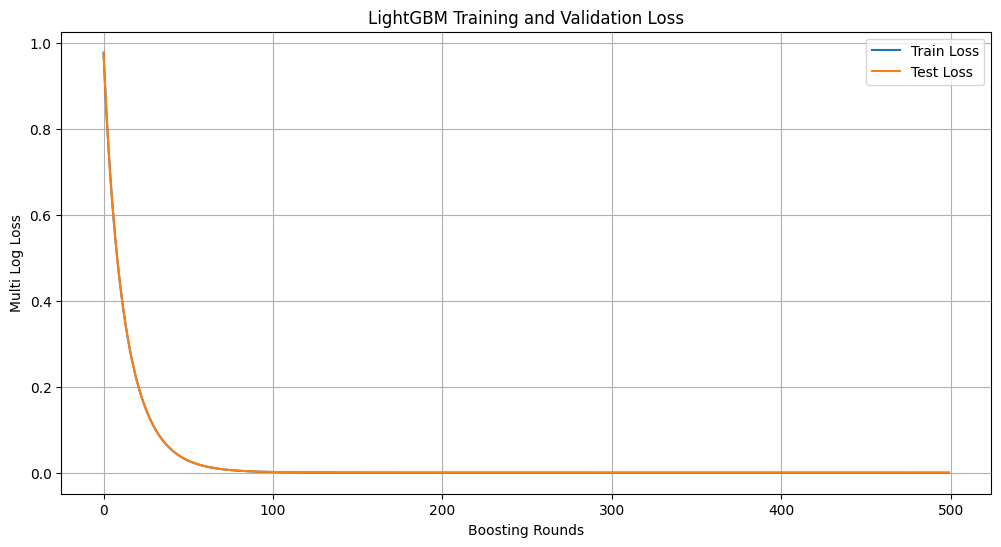

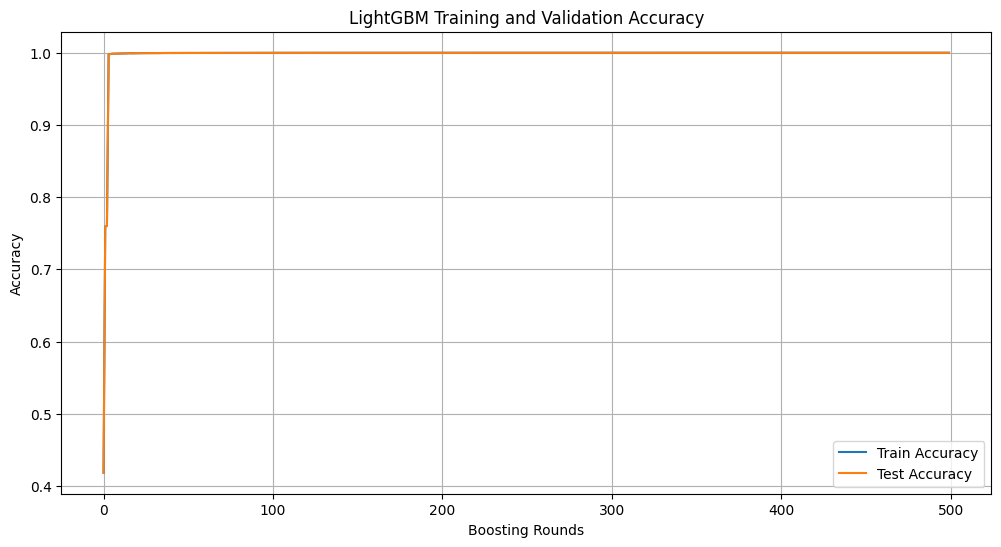

Final Train Loss: 0.000669
Final Test Loss: 0.001125
Final Train Accuracy: 0.9997
Final Test Accuracy: 0.9996


In [58]:
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'


print("Available keys in evals_result_:", list(model_lgb.evals_result_.keys()))


results = model_lgb.evals_result_

if 'validation_1' in results:
    train_key = 'training'
    test_key = 'validation_1'
elif 'valid_1' in results:
    train_key = 'training'
    test_key = 'valid_1'
else:
    # If only one key exists, it might be that both train and test are stored differently
    available_keys = list(results.keys())
    train_key = available_keys[0]  # First eval set is usually training
    test_key = available_keys[1] if len(available_keys) > 1 else available_keys[0]

print(f"Using train key: '{train_key}', test key: '{test_key}'")

epochs = len(results[train_key]['multi_logloss'])
x_axis = range(0, epochs)

# Plot train and test loss
plt.figure(figsize=(12, 6))
plt.plot(x_axis, results[train_key]['multi_logloss'], label='Train Loss')
plt.plot(x_axis, results[test_key]['multi_logloss'], label='Test Loss')
plt.xlabel('Boosting Rounds')
plt.ylabel('Multi Log Loss')
plt.title('LightGBM Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate and plot accuracy manually
train_acc = []
test_acc = []

for i in range(1, epochs + 1):
    train_pred = model_lgb.predict(X_train, num_iteration=i)
    test_pred = model_lgb.predict(X_test, num_iteration=i)

    train_acc.append(np.mean(train_pred == y_train))
    test_acc.append(np.mean(test_pred == y_test))

plt.figure(figsize=(12, 6))
plt.plot(x_axis, train_acc, label='Train Accuracy')
plt.plot(x_axis, test_acc, label='Test Accuracy')
plt.xlabel('Boosting Rounds')
plt.ylabel('Accuracy')
plt.title('LightGBM Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

print(f"Final Train Loss: {results[train_key]['multi_logloss'][-1]:.6f}")
print(f"Final Test Loss: {results[test_key]['multi_logloss'][-1]:.6f}")
print(f"Final Train Accuracy: {train_acc[-1]:.4f}")
print(f"Final Test Accuracy: {test_acc[-1]:.4f}")

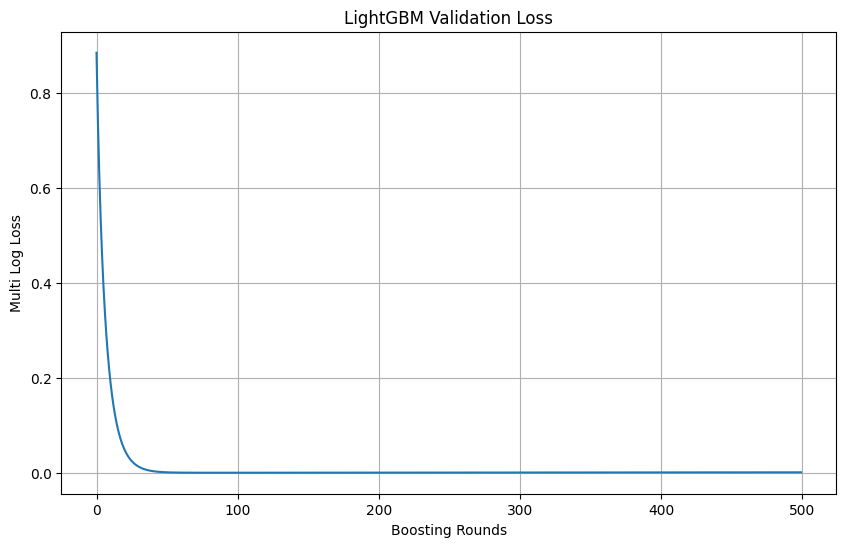

In [59]:
# model = LGBMClassifier(
#     n_estimators=500,
#     random_state=42,
#     verbose=-1
# )

model_lgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='multi_logloss'
)

results = model_lgb.evals_result_
key = list(results.keys())[0]
loss_values = results[key]['multi_logloss']

plt.figure(figsize=(10, 6))
plt.plot(range(len(loss_values)), loss_values)
plt.xlabel('Boosting Rounds')
plt.ylabel('Multi Log Loss')
plt.title('LightGBM Validation Loss')
plt.grid(True)
plt.show()

In [37]:
dup_count = pd.DataFrame(dataset).duplicated().sum()
print(f"Duplicate rows: {dup_count}")

Duplicate rows: 0


### Visualising feature importance

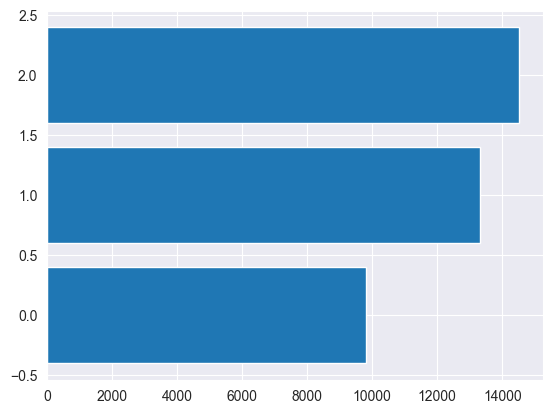

array([ 9816, 13306, 14529], dtype=int32)

In [38]:
importances = model_lgb.feature_importances_
plt.barh(range(len(importances)), importances)
plt.show()
importances

### Prediction of the unseen data

In [67]:
X_test_new = test[['accoustic_emmision_data', 'electrochemical_data', 'mechanical_data']]
y_test_actual = test['output']

y_test_pred = model_lgb.predict(X_test_new)

if hasattr(model_lgb, 'classes_') or (y_test_pred.dtype != object and y_test_pred.dtype != str):

    y_test_pred_labels = le.inverse_transform(y_test_pred)
else:
    y_test_pred_labels = y_test_pred


correct_predictions = (y_test_pred_labels == y_test_actual)
accuracy = correct_predictions.sum() / len(correct_predictions)

print(f"Total test samples: {len(test)}")
print(f"Correct predictions: {correct_predictions.sum()}")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Incorrect predictions: {len(test) - correct_predictions.sum()}")

Total test samples: 277892
Correct predictions: 277826
Accuracy: 0.9998 (99.98%)
Incorrect predictions: 66


### Prediction of individual row of dataset

In [65]:
new_data = pd.DataFrame({
    'accoustic_emmision_data': [2.76E+05],
    'electrochemical_data': [-7.73E-06],
    'mechanical_data': [0.040518072]
})
prediction = model_lgb.predict(new_data)
prediction_proba = model_lgb.predict_proba(new_data)
prediction_label = le.inverse_transform(prediction)

print(f"Predicted class: {prediction_label[0]}")
print("Prediction probabilities:")
for i, class_name in enumerate(le.classes_):
    print(f"{class_name}: {prediction_proba[0][i]:.4f}")

Predicted class: cathodic
Prediction probabilities:
anodic: 0.0000
cathodic: 1.0000
corrosion: 0.0000


### Model 2 : RandomForestClassifier

In [76]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

model_rf = RandomForestClassifier(n_estimators=500)

model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)

y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

      anodic       1.00      1.00      1.00     93066
    cathodic       1.00      1.00      1.00     76003
   corrosion       1.00      1.00      1.00     53244

    accuracy                           1.00    222313
   macro avg       1.00      1.00      1.00    222313
weighted avg       1.00      1.00      1.00    222313



### Prediction of the unseen data

In [593]:
X_test_new = test[['accoustic_emmision_data', 'electrochemical_data', 'mechanical_data']]
y_test_actual = test['output']

y_test_pred = model_rf.predict(X_test_new)

if hasattr(model_rf, 'classes_') or (y_test_pred.dtype != object and y_test_pred.dtype != str):

    y_test_pred_labels = le.inverse_transform(y_test_pred)
else:
    y_test_pred_labels = y_test_pred


correct_predictions = (y_test_pred_labels == y_test_actual)
accuracy = correct_predictions.sum() / len(correct_predictions)

print(f"Total test samples: {len(test)}")
print(f"Correct predictions: {correct_predictions.sum()}")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Incorrect predictions: {len(test) - correct_predictions.sum()}")

Total test samples: 317224
Correct predictions: 317134
Accuracy: 0.9997 (99.97%)
Incorrect predictions: 90


In [91]:
file_path = 'dataset/n1_n2_n3_cleaned/corrosion_N1.csv'
df = pd.read_csv(file_path)

required_columns = ['accoustic_emmision_data', 'electrochemical_data', 'mechanical_data']
df_selected = df[required_columns].copy()

predictions = model_rf.predict(df_selected)
prediction_probas = model_rf.predict_proba(df_selected)


df['predicted_class'] = predictions
df['prediction_confidence'] = np.max(prediction_probas, axis=1)

class_names = ['anodic', 'cathodic', 'corrosion']
df['predicted_class_name'] = df['predicted_class'].apply(lambda x: class_names[x])


print(df['predicted_class_name'].value_counts())
print(df.predicted_class_name.unique())


### Prediction of individual row of dataset

In [ ]:
new_data = pd.DataFrame({
    'accoustic_emmision_data': [830000.0],
    'electrochemical_data': [-1.690000e-07],
    'mechanical_data': [0.006410]
})
prediction = model_rf.predict(new_data)
prediction_proba = model_rf.predict_proba(new_data)
prediction_label = le.inverse_transform(prediction)

print(f"Predicted class: {prediction_label[0]}")
print("Prediction probabilities:")
for i, class_name in enumerate(le.classes_):
    print(f"{class_name}: {prediction_proba[0][i]:.4f}")

### Model 3 :  XGBooster

In [40]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)

model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)

y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

      anodic       1.00      1.00      1.00     93066
    cathodic       1.00      1.00      1.00     76003
   corrosion       1.00      1.00      1.00     53244

    accuracy                           1.00    222313
   macro avg       1.00      1.00      1.00    222313
weighted avg       1.00      1.00      1.00    222313



### Prediction of the unseen data

In [41]:
X_test_new = test[['accoustic_emmision_data', 'electrochemical_data', 'mechanical_data']]
y_test_actual = test['output']

y_test_pred = model_xgb.predict(X_test_new)

if hasattr(model_xgb, 'classes_') or (y_test_pred.dtype != object and y_test_pred.dtype != str):

    y_test_pred_labels = le.inverse_transform(y_test_pred)
else:
    y_test_pred_labels = y_test_pred


correct_predictions = (y_test_pred_labels == y_test_actual)
accuracy = correct_predictions.sum() / len(correct_predictions)

print(f"Total test samples: {len(test)}")
print(f"Correct predictions: {correct_predictions.sum()}")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Incorrect predictions: {len(test) - correct_predictions.sum()}")

Total test samples: 277892
Correct predictions: 277757
Accuracy: 0.9995 (99.95%)
Incorrect predictions: 135


In [92]:
# save_model.py
import pickle

import os
os.makedirs('model', exist_ok=True)

# Save model
with open('model/corrosion_model.pkl', 'wb') as f:
    pickle.dump(model_lgb, f)

# Save label encoder
with open('model/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print("✅ Model and label encoder saved successfully!")

✅ Model and label encoder saved successfully!
